In [1]:
import os
import cv2
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from xml.etree import ElementTree as et
#from torch_snippets import *

from IPython import display 
display.set_matplotlib_formats('svg')

from PIL import Image
from PIL import ImageFont, ImageDraw

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


https://blog.paperspace.com/train-yolov5-custom-data/

In [2]:
class_name_to_id_mapping = {"apple": 0,
                           "banana": 1,
                           "orange": 2}

def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in target: 
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        a.add_patch(rect)
    plt.show()
    
def color_image(img): 
    image = cv2.imread(img)
    image = cv2.cvtColor(image,  cv2.COLOR_BGR2RGB)
    return image 

def read_content(xml_file: str):
    # https://stackoverflow.com/questions/53317592/reading-pascal-voc-annotations-in-python
    tree = et.parse(xml_file)
    root = tree.getroot()
    
    #print(root.find('filename').text)
    yolo_list = []
    list_with_all_boxes = []
    
    filename = root.find('filename').text
    image_w = int(root.find("size/width").text)
    image_h = int(root.find("size/height").text)
    image_c = int(root.find("size/depth").text)
    
    for boxes in root.iter('object'):

        ymin, xmin, ymax, xmax = None, None, None, None
        
        name = boxes.find("name").text
        
        class_id = class_name_to_id_mapping[name]
        
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        
        
        
        b_center_x = (xmin + xmax) / 2 
        b_center_y = (ymin + ymax) / 2
        b_width    = (xmax - xmin)
        b_height   = (ymax - ymin)
        
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        yolo_item = [class_id, b_center_x, b_center_y, b_width, b_height]
        yolo_list.append(yolo_item)

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)

    return filename, list_with_all_boxes, yolo_list

read_content('../input/fruit-images-for-object-detection/test_zip/test/apple_77.xml')

('apple_77.jpg',
 [[71, 60, 175, 164],
  [12, 22, 105, 111],
  [134, 23, 243, 115],
  [107, 126, 216, 229],
  [207, 138, 298, 229]],
 [[0, 0.41, 0.4890829694323144, 0.3466666666666667, 0.45414847161572053],
  [0, 0.195, 0.2903930131004367, 0.31, 0.388646288209607],
  [0,
   0.6283333333333333,
   0.30131004366812225,
   0.36333333333333334,
   0.4017467248908297],
  [0,
   0.5383333333333333,
   0.7751091703056768,
   0.36333333333333334,
   0.4497816593886463],
  [0,
   0.8416666666666667,
   0.8013100436681223,
   0.30333333333333334,
   0.39737991266375544]])

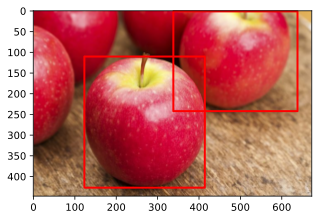

In [3]:
img_path = '../input/fruit-images-for-object-detection/test_zip/test/apple_94.jpg'
anns_path = '../input/fruit-images-for-object-detection/test_zip/test/apple_94.xml'

image = color_image(img_path)
filename, bboxes, _ = read_content(anns_path)

plot_img_bbox(image, bboxes)

# https://www.kaggle.com/code/yerramvarun/fine-tuning-faster-rcnn-using-pytorch/notebook

In [4]:
class CustomDataset(Dataset): 
    def __init__(self, file_dir, width, height, feature_extractor=None): 
        self.width = width 
        self.height = height 
        self.file_dir = file_dir
        self.feature_extractor = feature_extractor
        
        self.img = [i for i in os.listdir(file_dir) if i.endswith('.jpg')]  # Getting only the images 
        self.xml = [f'{i[:-4]}.xml' for i in self.img]  # chaning the image name to xml file. 
        self.classes = ['apple', 'banana', 'orange'] # labels of the images. 
        
    def __len__(self): 
        return len(self.img)
    
    def __getitem__(self, index): 
        img_name = self.img[index]  # indexing the image list 
        ann_name = self.xml[index]  # indexing the xml list 
        
        image_path = f'{self.file_dir}/{img_name}'  # making path for image path 
        ann_path = f'{self.file_dir}/{ann_name}' # making path for anns path 
        
        #image = color_image(image_path) # read the file and give the RGB format of the file! 
        #image_res = image.astype(np.float32)
        #image_res = cv2.resize(image_res, (self.width, self.height), cv2.INTER_AREA)
        #image_res /= 255.0  
        image_res = Image.open(image_path).convert('RGB')#.resize(self.width, self.height)
         
        
        wt = image.shape[1]
        ht = image.shape[0]
        
        tree = et.parse(ann_path)
        root = tree.getroot()
        
        list_with_all_boxes = []
        labels = []
        for boxes in root.iter('object'):
            labels.append(self.classes.index(boxes.find('name').text))

            ymin, xmin, ymax, xmax = None, None, None, None

            ymin = int(boxes.find("bndbox/ymin").text)
            xmin = int(boxes.find("bndbox/xmin").text)
            ymax = int(boxes.find("bndbox/ymax").text)
            xmax = int(boxes.find("bndbox/xmax").text)
            
            # The COCO bounding box format is [top left x position, top left y position, width, height].
            coco_xmin = xmin
            coco_ymin = ymin
            coco_width = xmax - xmin
            coco_height = ymax - ymin
            
            xmin_corr = (xmin/wt)*self.width 
            xmax_corr = (xmax/wt)*self.width 
            ymin_corr = (ymin/ht)*self.height 
            ymax_corr = (ymax/ht)*self.height 
                
            #list_with_single_boxes = [xmin_corr, ymin_corr, xmax_corr, ymax_corr]
            
            coco_list_with_single_boxes = [coco_xmin, coco_ymin, coco_width, coco_height]
            
            line = {'category_id': self.classes.index(boxes.find('name').text), 'bbox': coco_list_with_single_boxes, 'area': 1.0}
            
            #list_with_all_boxes.append(list_with_single_boxes)
            list_with_all_boxes.append(line)
            
        target = {}
        #target['boxes'] = list_with_all_boxes
        #target['labels'] = labels  
        #target['image_id'] = index 
        
        target['annotations'] = list_with_all_boxes
        #target['category_id'] = labels  
        target['image_id'] = index 
        
        
        if self.feature_extractor:
            return feature_extractor(images=image_res, annotations=target, return_tensors="pt")
        else:
            return image_res, target
        

In [5]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=512, max_size=864)

Downloading:   0%|          | 0.00/275 [00:00<?, ?B/s]

In [6]:
file_dir_train = '../input/fruit-images-for-object-detection/train_zip/train'
file_dir_test = '../input/fruit-images-for-object-detection/test_zip/test'

# Getting the dataset 
train_set = CustomDataset(file_dir_train, 224, 224, feature_extractor=feature_extractor)
test_set = CustomDataset(file_dir_test, 224, 224, feature_extractor=feature_extractor)

print(len(train_set), len(test_set))

# Let's get validation test 
train_set, valid_set = torch.utils.data.random_split(train_set, [190, 50])


def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = feature_extractor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    batch = {}
    batch['pixel_values'] = encoding['pixel_values']
    batch['labels'] = labels
    return batch


# Data Loader 
train_dataloader = DataLoader(train_set, batch_size = 1, shuffle = True, num_workers = 1)
val_dataloader = DataLoader(valid_set, batch_size = 1, shuffle = True, num_workers = 1)
test_loader = DataLoader(test_set, batch_size = 1, shuffle = False, num_workers = 1)
#train_dataloader = DataLoader(train_set, collate_fn=collate_fn, batch_size=1, shuffle=True)
#valid_dataloader = DataLoader(valid_set, collate_fn=collate_fn, batch_size=1)
#test_loader = DataLoader(test_set, collate_fn=collate_fn, batch_size=1)


240 60


In [7]:
test_set[9]["pixel_values"].shape
train_set[2]['labels']

[{'boxes': tensor([[0.4500, 0.6297, 0.6229, 0.7406]]),
  'class_labels': tensor([1]),
  'image_id': tensor([123]),
  'area': tensor([1.5236]),
  'iscrowd': tensor([0]),
  'orig_size': tensor([320, 700]),
  'size': tensor([395, 864])}]

(683, 512)
tensor([0.2130, 0.3554, 0.2313, 0.3461])
tensor(66.4787) tensor(93.3808) tensor(224.4793) tensor(270.5765)
tensor([0.2743, 0.6001, 0.2127, 0.2607])
tensor(114.7440) tensor(240.5125) tensor(259.9953) tensor(373.9786)
tensor([0.5653, 0.1495, 0.5067, 0.2117])
tensor(213.0960) tensor(22.3203) tensor(559.1493) tensor(130.7331)
tensor([0.5947, 0.2989, 0.4693, 0.2278])
tensor(245.8800) tensor(94.7473) tensor(566.4346) tensor(211.3594)
tensor([0.5950, 0.3892, 0.5153, 0.2429])
tensor(230.3987) tensor(137.1103) tensor(582.3713) tensor(261.4662)


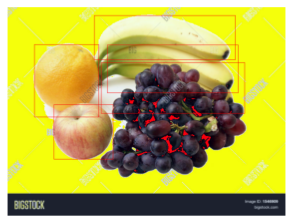

In [8]:
tensor = test_set[9]['pixel_values'][0]
boxes = test_set[9]['labels'][0]['boxes']

tensor = 0.225 * tensor + 0.456

img = T.ToPILImage()(tensor)

print(img.size)
plt.figure(figsize=(5, 5))

draw = ImageDraw.Draw(img)
for box in boxes:
    print(box)
    x1, y1, w_size, h_size = box[0], box[1], box[2], box[3] 
    x_start = (x1 - (w_size/2)) * img.size[0]
    y_start = (y1 - (h_size/2)) * img.size[1]
    x_end = (x_start + w_size * img.size[0]) 
    y_end = (y_start + h_size * img.size[1]) 
    print(x_start, y_start, x_end, y_end)
    draw.rectangle(((x_start, y_start), (x_end, y_end)), outline ="red")
    
plt.imshow(img)
plt.axis('off')
plt.show()

In [9]:
from transformers import DetrConfig, AutoModelForObjectDetection

#model = Detr(lr=2.5e-5, weight_decay=1e-4)
model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-small", num_labels=3, ignore_mismatched_sizes=True)

lr=2.5e-5
weight_decay=1e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
#model

Downloading:   0%|          | 0.00/4.04k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/117M [00:00<?, ?B/s]

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([4, 384]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
if torch.cuda.is_available():  
    model.cuda()

In [11]:
for epoch_num in range(40):
    train_loss = 0
    train_loss_ce = 0
    train_loss_bbox = 0
    valid_loss = 0
    valid_loss_ce = 0
    valid_loss_bbox = 0
    loss = 0
    
    # Train loop   
    model.train()
    #print("Train step")
    for ii, batch in enumerate(iter(train_dataloader)):
        #print(batch["labels"])
        pixel_values = batch['pixel_values'][0]
        
        if torch.cuda.is_available():
            pixel_values = pixel_values.cuda()
            

        if torch.cuda.is_available():  
            labels = [{k: v[0].cuda() for k, v in t.items()} for t in batch['labels']]
        else:
            labels = [{k: v[0] for k, v in t.items()} for t in batch['labels']]
        
        #print(labels)
        
        outputs = model(pixel_values=pixel_values, labels=labels)
        
        #print(outputs)

        loss += outputs.loss
        if (ii+1)%4 == 0:       
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss = 0
        
        #train_loss += loss.item()
        train_loss_ce += outputs.loss_dict['loss_ce'].item()
        train_loss_bbox += outputs.loss_dict['loss_bbox'].item()
        
        #if ii%10 == 0:
        #    print("Iter {}, Loss = {:.4f} {:.4f} {:.4f}".format(ii, loss.item(), outputs.loss_dict['loss_ce'].item(), outputs.loss_dict['loss_bbox'].item()))

    # Valid loop 
    model.eval()
    #print("Eval step")
    for ii, batch in enumerate(iter(val_dataloader)):
        
        if torch.cuda.is_available():
            pixel_values = pixel_values.cuda()
        
        if torch.cuda.is_available():  
            labels = [{k: v[0].cuda() for k, v in t.items()} for t in batch['labels']]
        else:
            labels = [{k: v[0] for k, v in t.items()} for t in batch['labels']]
        
        outputs = model(pixel_values=pixel_values, labels=labels)

        #loss = outputs.loss
        
        #valid_loss += loss.item()
        valid_loss_ce += outputs.loss_dict['loss_ce'].item()
        valid_loss_bbox += outputs.loss_dict['loss_bbox'].item()
        
    print("Epoch {}, Train loss {:.4f}, CE={:.4f}, BBOX={:.4f}".format(epoch_num+1, train_loss, train_loss_ce, train_loss_bbox))
    print("Epoch {}, Valid loss {:.4f}, CE={:.4f}, BBOX={:.4f}".format(epoch_num+1, valid_loss, valid_loss_ce, valid_loss_bbox))

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1, Train loss 0.0000, CE=124.5599, BBOX=14.9377
Epoch 1, Valid loss 0.0000, CE=30.9877, BBOX=12.4864


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 2, Train loss 0.0000, CE=80.1451, BBOX=12.6466
Epoch 2, Valid loss 0.0000, CE=39.9681, BBOX=13.9636


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 3, Train loss 0.0000, CE=50.9512, BBOX=13.3106
Epoch 3, Valid loss 0.0000, CE=41.6722, BBOX=12.1654


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 4, Train loss 0.0000, CE=35.3605, BBOX=12.0584
Epoch 4, Valid loss 0.0000, CE=45.4237, BBOX=11.1438


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 5, Train loss 0.0000, CE=29.0631, BBOX=12.2767
Epoch 5, Valid loss 0.0000, CE=49.1460, BBOX=17.3909


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 6, Train loss 0.0000, CE=26.0679, BBOX=11.8119
Epoch 6, Valid loss 0.0000, CE=45.9174, BBOX=17.7319


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 7, Train loss 0.0000, CE=24.6495, BBOX=10.6701
Epoch 7, Valid loss 0.0000, CE=42.9981, BBOX=15.7636


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 8, Train loss 0.0000, CE=21.0176, BBOX=9.9316
Epoch 8, Valid loss 0.0000, CE=45.3132, BBOX=12.0694


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 9, Train loss 0.0000, CE=17.9886, BBOX=9.3319
Epoch 9, Valid loss 0.0000, CE=51.6082, BBOX=19.7779


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 10, Train loss 0.0000, CE=18.7867, BBOX=10.3573
Epoch 10, Valid loss 0.0000, CE=57.2975, BBOX=15.9930


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 11, Train loss 0.0000, CE=14.5817, BBOX=9.8486
Epoch 11, Valid loss 0.0000, CE=44.2633, BBOX=18.9094


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 12, Train loss 0.0000, CE=13.0226, BBOX=8.8591
Epoch 12, Valid loss 0.0000, CE=52.6972, BBOX=15.9279


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 13, Train loss 0.0000, CE=12.1323, BBOX=8.6422
Epoch 13, Valid loss 0.0000, CE=46.9035, BBOX=14.4449


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 14, Train loss 0.0000, CE=10.2781, BBOX=7.1910
Epoch 14, Valid loss 0.0000, CE=50.9742, BBOX=13.0274


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 15, Train loss 0.0000, CE=8.5668, BBOX=6.6264
Epoch 15, Valid loss 0.0000, CE=59.3701, BBOX=12.1113


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 16, Train loss 0.0000, CE=10.1312, BBOX=7.2171
Epoch 16, Valid loss 0.0000, CE=61.6234, BBOX=15.0977


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 17, Train loss 0.0000, CE=8.1076, BBOX=6.6548
Epoch 17, Valid loss 0.0000, CE=63.1192, BBOX=13.4167


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 18, Train loss 0.0000, CE=9.6924, BBOX=7.0421
Epoch 18, Valid loss 0.0000, CE=53.2147, BBOX=12.2943


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 19, Train loss 0.0000, CE=9.5478, BBOX=7.0671
Epoch 19, Valid loss 0.0000, CE=57.8212, BBOX=11.9808


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 20, Train loss 0.0000, CE=7.3820, BBOX=6.1770
Epoch 20, Valid loss 0.0000, CE=63.8183, BBOX=12.4142


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 21, Train loss 0.0000, CE=6.6752, BBOX=5.5849
Epoch 21, Valid loss 0.0000, CE=62.7059, BBOX=14.6915


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 22, Train loss 0.0000, CE=5.6719, BBOX=5.1990
Epoch 22, Valid loss 0.0000, CE=67.8272, BBOX=20.8203


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 23, Train loss 0.0000, CE=4.8342, BBOX=5.0113
Epoch 23, Valid loss 0.0000, CE=71.2819, BBOX=10.4322


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 24, Train loss 0.0000, CE=4.4516, BBOX=4.8643
Epoch 24, Valid loss 0.0000, CE=58.9348, BBOX=16.6462


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 25, Train loss 0.0000, CE=4.0167, BBOX=5.0739
Epoch 25, Valid loss 0.0000, CE=74.3403, BBOX=15.3728


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 26, Train loss 0.0000, CE=3.8980, BBOX=4.7400
Epoch 26, Valid loss 0.0000, CE=66.4149, BBOX=13.2727


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 27, Train loss 0.0000, CE=2.9541, BBOX=4.5446
Epoch 27, Valid loss 0.0000, CE=74.0855, BBOX=16.9308


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 28, Train loss 0.0000, CE=2.3717, BBOX=4.1003
Epoch 28, Valid loss 0.0000, CE=73.0244, BBOX=14.8325


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 29, Train loss 0.0000, CE=2.2201, BBOX=4.2126
Epoch 29, Valid loss 0.0000, CE=78.9532, BBOX=19.4875


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 30, Train loss 0.0000, CE=1.7545, BBOX=3.8159
Epoch 30, Valid loss 0.0000, CE=76.7289, BBOX=17.0432


[{'boxes': tensor([[0.2750, 0.5569, 0.4750, 0.6750]]), 'class_labels': tensor([2]), 'image_id': tensor([97]), 'area': tensor([0.5052]), 'iscrowd': tensor([0]), 'orig_size': tensor([720, 960]), 'size': tensor([512, 682])}]
(682, 512)
79 30 114 345 454 0.99578995 2


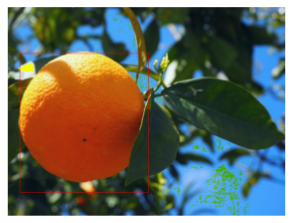

In [23]:
def test_pred(i, set, thr=0.4):
    batch = set[i]
    pixel_values = batch['pixel_values']#[0]
    outputs = model(pixel_values=pixel_values.cuda())

    #outputs
    print(batch['labels'])

    outputs_softmax = torch.softmax(outputs.logits.detach(), dim=-1)[0, :, :-1]
    probs = torch.max(outputs_softmax, dim=-1).values.cpu()
    pred_class = torch.max(outputs_softmax, dim=-1).indices.cpu()

    tensor = pixel_values[0].cpu()
    boxes = outputs.pred_boxes[0].cpu().detach().numpy()

    tensor = 0.225 * tensor + 0.456

    img = T.ToPILImage()(tensor)

    print(img.size)
    plt.figure(figsize=(5, 5))

    draw = ImageDraw.Draw(img)
    for n, box in enumerate(boxes):
        #print(box)
        x1, y1, w_size, h_size = box[0], box[1], box[2], box[3] 
        x_start = (x1 - (w_size/2)) * img.size[0]
        y_start = (y1 - (h_size/2)) * img.size[1]
        x_end = (x_start + w_size * img.size[0]) 
        y_end = (y_start + h_size * img.size[1]) 

        if probs[n]>thr:
            print(n, int(x_start), int(y_start), int(x_end), int(y_end), probs[n].numpy(), pred_class[n].numpy())
            draw.rectangle(((x_start, y_start), (x_end, y_end)), outline ="red")

    plt.imshow(img)
    plt.axis('off')
    plt.show()
test_pred(0, train_set)

[{'boxes': tensor([[0.5080, 0.6524, 0.5417, 0.5143]]), 'class_labels': tensor([1]), 'image_id': tensor([228]), 'area': tensor([5.9390]), 'iscrowd': tensor([0]), 'orig_size': tensor([210, 312]), 'size': tensor([512, 760])}]
(760, 512)
46 179 206 594 463 0.9917395 1
97 180 68 346 225 0.6625906 0


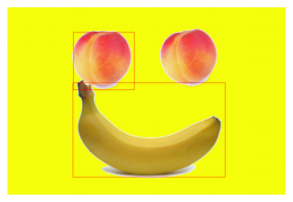

[{'boxes': tensor([[0.6761, 0.5216, 0.5144, 0.7899]]), 'class_labels': tensor([0]), 'image_id': tensor([51]), 'area': tensor([0.2920]), 'iscrowd': tensor([0]), 'orig_size': tensor([ 947, 1320]), 'size': tensor([512, 713])}]
(713, 512)
89 302 64 662 469 0.99499077 0


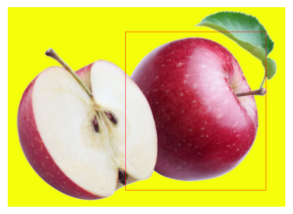

[{'boxes': tensor([[0.4786, 0.4686, 0.5114, 0.4857]]), 'class_labels': tensor([2]), 'image_id': tensor([157]), 'area': tensor([2.1400]), 'iscrowd': tensor([0]), 'orig_size': tensor([350, 350]), 'size': tensor([512, 512])}]
(512, 512)
48 114 115 371 357 0.984772 2


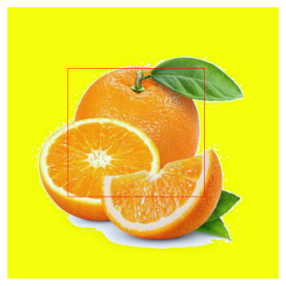

[{'boxes': tensor([[0.3057, 0.4889, 0.4844, 0.8444]]), 'class_labels': tensor([2]), 'image_id': tensor([80]), 'area': tensor([0.8100]), 'iscrowd': tensor([0]), 'orig_size': tensor([540, 960]), 'size': tensor([486, 864])}]
(864, 486)
92 61 35 470 444 0.9871608 2


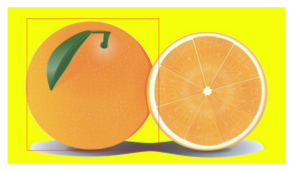

[{'boxes': tensor([[0.5098, 0.5137, 0.6465, 0.9154]]), 'class_labels': tensor([2]), 'image_id': tensor([137]), 'area': tensor([0.4440]), 'iscrowd': tensor([0]), 'orig_size': tensor([ 768, 1024]), 'size': tensor([512, 682])}]
(682, 512)
68 129 31 569 494 0.99713945 2


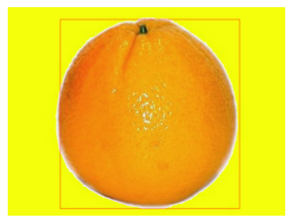

[{'boxes': tensor([[0.4519, 0.6725, 0.7094, 0.4841],
        [0.1802, 0.1822, 0.3587, 0.3632],
        [0.3216, 0.1654, 0.4594, 0.3261]]), 'class_labels': tensor([0, 0, 0]), 'image_id': tensor([209]), 'area': tensor([0.2045, 0.2045, 0.2045]), 'iscrowd': tensor([0, 0, 0]), 'orig_size': tensor([1696, 1132]), 'size': tensor([767, 512])}]
(512, 767)
26 2 4 350 466 0.4825373 0
47 0 2 181 282 0.9948133 0
76 57 337 414 717 0.9950694 0
90 47 2 278 251 0.9729994 0


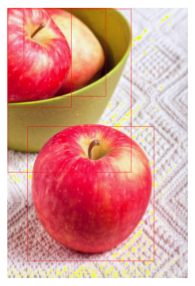

[{'boxes': tensor([[0.4960, 0.5900, 0.7840, 0.7320]]), 'class_labels': tensor([0]), 'image_id': tensor([165]), 'area': tensor([4.1943]), 'iscrowd': tensor([0]), 'orig_size': tensor([250, 250]), 'size': tensor([512, 512])}]
(512, 512)
94 55 117 454 488 0.99951553 0


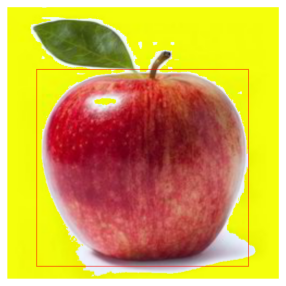

[{'boxes': tensor([[0.4480, 0.5052, 0.3203, 0.8902]]), 'class_labels': tensor([1]), 'image_id': tensor([26]), 'area': tensor([0.6930]), 'iscrowd': tensor([0]), 'orig_size': tensor([865, 615]), 'size': tensor([720, 512])}]
(512, 720)
45 149 42 305 686 0.96984416 1


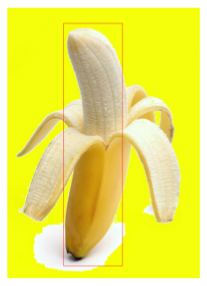

[{'boxes': tensor([[0.2445, 0.5836, 0.2141, 0.4582],
        [0.2297, 0.3386, 0.2125, 0.4006],
        [0.7625, 0.5490, 0.2063, 0.4179],
        [0.8148, 0.3401, 0.2328, 0.3746],
        [0.6039, 0.4236, 0.2234, 0.4150],
        [0.4930, 0.5706, 0.2359, 0.4092],
        [0.3789, 0.2738, 0.2078, 0.3631]]), 'class_labels': tensor([2, 2, 2, 2, 2, 2, 2]), 'image_id': tensor([146]), 'area': tensor([1.8186, 1.8186, 1.8186, 1.8186, 1.8186, 1.8186, 1.8186]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0]), 'orig_size': tensor([347, 640]), 'size': tensor([468, 863])}]
(863, 468)
47 106 65 291 252 0.9794296 2
65 565 152 762 352 0.99576086 2
69 594 67 802 254 0.9793798 2
76 322 168 531 364 0.99843055 2
79 113 166 321 377 0.9946037 2
96 435 97 641 290 0.8866191 2
97 237 40 427 229 0.99532616 2


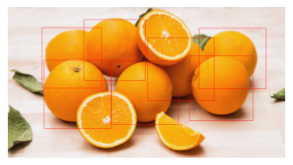

In [29]:
for i in range(11, 20):
    test_pred(i, train_set)

[{'boxes': tensor([[0.4710, 0.4765, 0.8920, 0.8185]]), 'class_labels': tensor([1]), 'image_id': tensor([215]), 'area': tensor([0.7400]), 'iscrowd': tensor([0]), 'orig_size': tensor([ 595, 1000]), 'size': tensor([512, 860])}]
(860, 512)
17 29 130 837 458 0.5475003 1
20 333 39 802 462 0.6334543 1
68 27 46 835 480 0.8619561 1
93 25 252 558 467 0.9340711 1


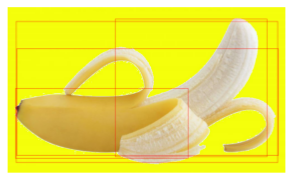

[{'boxes': tensor([[0.3250, 0.6600, 0.4180, 0.5893],
        [0.7250, 0.6000, 0.4100, 0.6720],
        [0.4910, 0.2293, 0.4380, 0.4533]]), 'class_labels': tensor([2, 2, 2]), 'image_id': tensor([67]), 'area': tensor([1.8623, 1.8623, 1.8623]), 'iscrowd': tensor([0, 0, 0]), 'orig_size': tensor([375, 500]), 'size': tensor([512, 682])}]
(682, 512)
20 453 -2 683 192 0.6365688 2
34 178 4 473 229 0.98380166 2
59 1 1 220 200 0.8718179 2
67 88 169 363 506 0.9766251 2
76 211 418 513 511 0.9050613 2
89 367 129 638 493 0.9933708 2


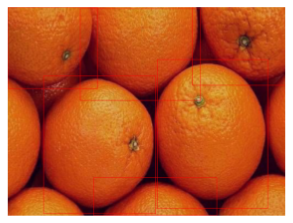

[{'boxes': tensor([[0.6097, 0.4866, 0.4354, 0.4955],
        [0.7494, 0.2218, 0.4512, 0.4407],
        [0.1722, 0.2574, 0.3428, 0.5059],
        [0.1088, 0.6810, 0.2160, 0.6231],
        [0.3916, 0.8331, 0.4012, 0.3338],
        [0.8424, 0.8561, 0.3136, 0.2878]]), 'class_labels': tensor([1, 1, 1, 1, 1, 1]), 'image_id': tensor([0]), 'area': tensor([0.5196, 0.5196, 0.5196, 0.5196, 0.5196, 0.5196]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0]), 'orig_size': tensor([ 674, 1199]), 'size': tensor([486, 864])}]
(864, 486)
3 565 367 870 484 0.6267838 1
27 428 1 840 255 0.73765165 1
87 335 107 723 350 0.8141316 1


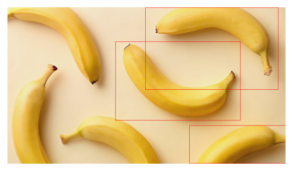

[{'boxes': tensor([[0.5120, 0.5204, 0.7981, 0.7909]]), 'class_labels': tensor([2]), 'image_id': tensor([181]), 'area': tensor([1.5148]), 'iscrowd': tensor([0]), 'orig_size': tensor([416, 416]), 'size': tensor([512, 512])}]
(512, 512)
45 73 64 462 456 0.99795085 2


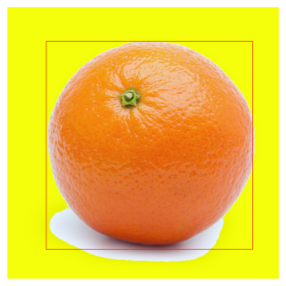

[{'boxes': tensor([[0.2700, 0.5293, 0.4000, 0.6209],
        [0.6967, 0.5458, 0.4233, 0.6794]]), 'class_labels': tensor([2, 2]), 'image_id': tensor([85]), 'area': tensor([1.6958, 1.6958]), 'iscrowd': tensor([0, 0]), 'orig_size': tensor([393, 600]), 'size': tensor([512, 781])}]
(781, 512)
79 60 111 360 433 0.9978258 2
89 389 102 705 422 0.9980398 2


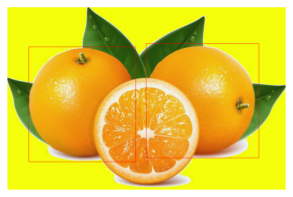

[{'boxes': tensor([[0.5033, 0.5972, 0.5344, 0.6004]]), 'class_labels': tensor([0]), 'image_id': tensor([71]), 'area': tensor([1.2480]), 'iscrowd': tensor([0]), 'orig_size': tensor([458, 610]), 'size': tensor([512, 681])}]
(681, 512)
17 161 146 519 462 0.9976331 0


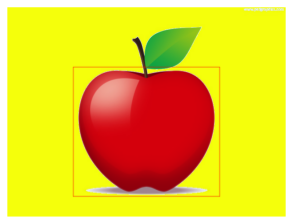

[{'boxes': tensor([[0.4971, 0.5600, 0.7118, 0.6444]]), 'class_labels': tensor([1]), 'image_id': tensor([12]), 'area': tensor([1.2934]), 'iscrowd': tensor([0]), 'orig_size': tensor([450, 680]), 'size': tensor([512, 773])}]
(773, 512)
79 121 126 645 448 0.98620945 1


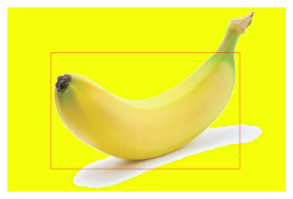

[{'boxes': tensor([[0.5219, 0.4403, 0.5125, 0.7073],
        [0.3953, 0.5679, 0.6219, 0.6019],
        [0.4406, 0.3009, 0.4875, 0.4567]]), 'class_labels': tensor([1, 1, 1]), 'image_id': tensor([87]), 'area': tensor([1.4370, 1.4370, 1.4370]), 'iscrowd': tensor([0, 0, 0]), 'orig_size': tensor([427, 640]), 'size': tensor([512, 767])}]
(767, 512)
24 112 36 615 322 0.50661975 1
34 221 53 626 388 0.9980919 1
48 111 35 471 295 0.81407034 1
59 102 33 468 316 0.9946621 1


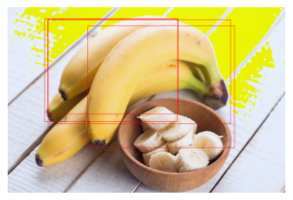

[{'boxes': tensor([[0.5094, 0.5047, 0.8562, 0.8344]]), 'class_labels': tensor([2]), 'image_id': tensor([6]), 'area': tensor([2.5600]), 'iscrowd': tensor([0]), 'orig_size': tensor([320, 320]), 'size': tensor([512, 512])}]
(512, 512)
68 45 41 459 464 0.9900922 2


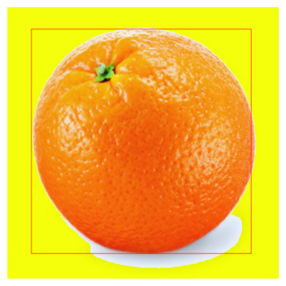

In [28]:
for i in range(21, 30):
    test_pred(i, valid_set)